# Project: Wrangling and Analyzing Data

This project corresponds to data wrangling project within Udacity Data Analyst Nanodegree. The purpose of this analysis is to gather data from a variety of sources, including scrapping data from @WeRateDogs Twitter API, and assess its quality and tidiness, then clean it and finally create interesting and credible analyses and visualizations. The dataset that we wrangle (and analyze and visualize) is the tweet archive of Twitter user [@WeRateDogs](https://twitter.com/dog_rates) which often scores account users'dogs above 10/10, accompanying humorous texts and pictures of dogs. @WeRateDogs was created in 2015 and has currently acquired 9.3+ million followers worldwide. 

## Table of Contents
<ul>
<li><a href="#gathering">Data Gathering</a></li>
<li><a href="#assessing">Assessing Data</a></li>
<li><a href="#cleaning">Cleaning Data</a></li>
<li><a href="#storing">Storing Data</a></li>
<li><a href="#analyzing">Analyzing and Visualizing Data</a></li>
<li><a href="#limitations">Limitations</a></li>
</ul>

<a id='gathering'></a>
## Data Gathering

1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv). This archive data contains basic tweet data (tweet ID, timestamp, text, etc.) for over 2k of their tweets with their ratings from 2015 to August 1, 2017. 

In [1]:
# Import neccesary libraries
import pandas as pd
import numpy as np
import json
import requests
import tweepy
from tweepy import OAuthHandler

# Read twitter_archive_enhanced.csv into a dataframe
df1=pd.read_csv('twitter-archive-enhanced.csv')
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image predictions (image_predictions.tsv). This dataset contains three image predictions alongside with their tweet ID, image url, and the image number that corresponded to the highest confident prediction.

In [2]:
# Download image_predictions.tsv file from the mentioned url using the Request library
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)

# Write to the downloaded image-predictions.tsv file 
with open ('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)

# Load it into image_df
image_df = pd.read_csv('image-predictions.tsv',sep="\t")
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt). This Twitter API contains information about the retweet_count and favorite_count for each tweet in @WeRateDogs. This data will be combined with the archive data loaded into df1 data frame above based on the tweet ID key. 

In [3]:
# Use Python's Tweepy library to scrap data via the Twitter API 
consumer_key = 'hidden'
consumer_secret = 'hidden'
access_token = 'hidden'
access_secret = 'hidden'
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [4]:
# Store each tweet into a json file called tweet_json.txt by reading tweet_json.txt line by line into lists with keys including tweet_id, retweet_count and favorite_count
retweet_and_favorite_count = []
not_found_tweet_id = []

with open('tweet_json.txt', mode="w") as file:
    for t in df1.tweet_id.values:
        try:
            tweet = api.get_status(t)
            file.write(json.dumps(tweet._json))
            retweet_and_favorite_count.append({
                "tweet_id" :t,
                "retweet_count" : tweet._json['retweet_count'],
                "favorite_count" : tweet._json['favorite_count']})
        except:
            not_found_tweet_id.append(t) 

# Convert df_list to DataFrame
df2=pd.DataFrame(retweet_and_favorite_count,columns=['tweet_id','retweet_count','favorite_count'])
df2.head()

Rate limit reached. Sleeping for: 725
Rate limit reached. Sleeping for: 724


,tweet_id,retweet_count,favorite_count
0,892420643555336193,6964,33670
1,892177421306343426,5268,29212
2,891815181378084864,3463,21954
3,891689557279858688,7182,36728
4,891327558926688256,7709,35161


<a id='assessing'></a>
## Assessing Data
In this section, we detect and document quality issues and tidiness issues by using both visual assessment
programmatic assessement to assess the data.

**Visual assessment**

In [5]:
# Visually assess DataFrame of The WeRateDogs Twitter archive
df1

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


* Most of the information of replies and retweets are null.

* Rating information is recorded in two seperated columns, which should be combined into one column by feature engineering.

* Four columns contain only one unit of information - the stage of dog which violates the principle of data tidiness. 

* Many dog's names are defined as a, an, the, instead of being null.

* Source field seems to have duplicated values.

In [6]:
# Visually assess DataFrame of additional data on tweets with its retweet counts and favorite counts scraped from Twitter API
df2

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6964,33670
1,892177421306343426,5268,29212
2,891815181378084864,3463,21954
3,891689557279858688,7182,36728
4,891327558926688256,7709,35161
5,891087950875897856,2583,17735
6,890971913173991426,1646,10323
7,890729181411237888,15669,56624
8,890609185150312448,3602,24396
9,890240255349198849,6063,27833


* There are 2327 observations and 3 columns in this dataframe. There are less instances in this df2 than that of df1.

In [7]:
# Visually assess DataFrame of the tweet image predictions
image_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


* There are three different predictions of what type of dogs are and in some of rows (i.e row indexes 6, 17, and 18), all three predictions are non-dogs. They are not helpful for predicting and should be removed.

* Dogs'predicted breeds are inconsistent in their forms, some are lowercase while some are uppercase.

**Programatically assessment**

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

* Tweet ids are integers while they should be in form of strings.
* There are information about replies and retweets while we just focus on original tweet patterns. Also, many of observations of replies and retweets are null. 
* Timestamp has wrong data type, which is string instead of datetime.

In [9]:
df1.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


* Rating denominator has inaccurate values which are not equal to 10. It can just get one value of 10 in this WeRateDog Tweets' unique rating system.

In [10]:
df1.duplicated().sum()

0

In [11]:
sum(df1.source.duplicated())

2352

* There are 2352 duplicated values in source columns, which means that 99.8% of values comes from one same source.

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
tweet_id          2327 non-null int64
retweet_count     2327 non-null int64
favorite_count    2327 non-null int64
dtypes: int64(3)
memory usage: 54.6 KB


* Same issue as in df1, Tweet ids in df2 are integers while they also should be strings.

In [13]:
df2.sample(5)

,tweet_id,retweet_count,favorite_count
1874,674638615994089473,509,1511
1029,742150209887731712,1391,4693
1742,678334497360859136,222,1179
643,790946055508652032,4370,15810
2280,666804364988780544,78,206


In [14]:
df2.duplicated().sum()

0

In [15]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* Tweet ids are integers while they should be in form of strings.

In [16]:
image_df.duplicated().sum()

0

In [17]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


### Assessing Data Summary

### Quality issues
#### df1 
* Tweet ids are integers while they should be in form of strings.

* Replies and retweets' records are incomplete, 78 and 181 non-null respectively.

* Timestamp has wrong data type, string instead of datetime.

* Inaccurate value exists in rating_denomenator field, which should equal 10.

* Rating_numerator and rating_denomenator are two columns to measure rating of a tweet

* Some dog's unidentifed names such as a,an,the will be replaced to be null values instead.

* Source column contain 2352 duplicated values. This column is therefore not helpful for analysis and need to be dropped out.

#### df2
* Tweet ids are integers while they should be strings.

#### image_df
* Tweet ids have wrong data types. 

* There are predictions that turn out to be non-dogs

### Tidiness issues

* Four columns in df1 represent one unit information about the phase of a dog. 
* Merging df1 with df2 using tweet_id as the common key to make the dataset for analysis complete.

<a id='cleaning'></a>
## Cleaning Data

In [18]:
# Make copies of original pieces of data
df1_clean=df1.copy()
df2_clean=df2.copy()
image_df_clean=image_df.copy()

### Tidiness issue
#### Issue #1: 

##### Define:   Combine four columns ["doggo", "floofer", "pupper", "puppo"] into one "dog_stage" column, then drop those four columns from df1_clean dataframe

#### Code

In [19]:
# Put dog stages into one column.
dog_stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']
# Replace None in stage columns with empty string.
df1_clean[dog_stage_cols] = df1_clean[dog_stage_cols].replace('None', '')
# Then combine stage columns.
df1_clean['stage'] = df1_clean.doggo + df1_clean.floofer + df1_clean.pupper + df1_clean.puppo
# Check if there are multiple stages in any tweet.
df1_clean['stage'].value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: stage, dtype: int64

In [20]:
# Deal with multiple stages in any tweet.
df1_clean.loc[df1_clean.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
df1_clean.loc[df1_clean.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
df1_clean.loc[df1_clean.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'
# Handle missing values
df1_clean.loc[df1_clean.stage == '', 'stage'] = np.nan

#### Test

In [21]:
df1_clean['stage'].value_counts()

pupper            245
doggo              83
puppo              29
doggo, pupper      12
floofer             9
doggo, puppo        1
doggo, floofer      1
Name: stage, dtype: int64

In [22]:
df1_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis =1, inplace=True)
df1_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


#### Issue #2+3: 

##### Define:  Merge df1 and df2 on tweet_id since retweet_count and favorite_count should be a part of original tweet dataset. Since tweet_ids are defined as integer in df1 and df2, before merging two datasets, we have to convert the datatypes of them into string.

#### Code

In [23]:
# Convert tweet ids in df1 and df2 from integers to strings
df1_clean['tweet_id']=df1_clean['tweet_id'].astype(str)
df2_clean['tweet_id']=df2_clean['tweet_id'].astype(str)
# Merge df1 and df2 tables based on the common key 'tweet_id'
df1_clean = pd.merge(df1_clean,df2_clean,how='left',on='tweet_id')

#### Test

In [24]:
df1_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count
975,750041628174217216,NaN,NaN,2016-07-04 19:00:33 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Beau. He's trying to keep his daddy fr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750041628...,13,10,Beau,NaN,563.0,2947.0


### Quality Issue
#### Issue #4: 

##### Define: Remove 181 retweets from df1, and drop all columns related to retweets,  which are [ 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'] 

#### Code

In [25]:
# Find the rows of retweets
retweets = df1_clean[df1_clean["retweeted_status_id"].notnull()]
# Drop retweets by using their indexes
df1_clean.drop(axis=0, index=retweets.index, inplace=True)
# Drop three columns related to retweets,  which are ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
df1_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'],axis=1, inplace = True)

#### Test

In [26]:
df1_clean.shape

(2175, 13)

* 181 rows and 3 columns contained retweets are deleted from df1 since the original df1 has 2356 rows and 17 columns.

#### Issue #5: 

##### Define: Remove 78 replies from df1, and drop two columns related to replies,  which are [ 'in_reply_to_status_id', 'in_reply_to_user_id'] 

#### Code

In [27]:
# Find the rows of replies
replies = df1_clean[df1_clean["in_reply_to_status_id"].notnull()]
# Drop replies by using their indexes
df1_clean.drop(axis=0, index=replies.index, inplace=True)
# Drop two columns related to replies,  which are ['in_reply_to_status_id', 'in_reply_to_user_id'] 
df1_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'],axis=1, inplace = True)

#### Test

In [28]:
df1_clean.shape

(2097, 11)

#### Issue #6+7: 

#### Define: Drop rows with values of rating_denomenator columns in df1_clean to be not 10. And then, generate a new column 'rating' using rating_numerator divided by rating_denominator, and later drop rating_numerator and rating_denominator columns. 

* The fact that the rating numerators are greater than the denominators is explained in this [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent). This rating system is a big part of the popularity of @WeRateDogs tweets.

##### Code

In [29]:
# Check how many values are not equal 10
df1_clean.rating_denominator.value_counts()

10     2080
50        3
11        2
80        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

In [30]:
# Filter out the rows where rating_denominator are not equal 10
not_10=df1_clean[df1_clean['rating_denominator']!=10]
# Drop out those row indexes
df1_clean.drop(index=not_10.index,inplace=True)
# Engineer feature to create new rating column
df1_clean['rating'] = df1_clean['rating_numerator'] / df1_clean['rating_denominator']

##### Test

In [31]:
# Check if there are still rows whose rating_denominator not equal 10
df1_clean[df1_clean['rating_denominator']!=10]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,retweet_count,favorite_count,rating


In [32]:
# Drop two columns ['rating_numerator','rating_denominator'] and test whether they are removed
df1_clean.drop(columns = ['rating_numerator', 'rating_denominator'],axis=1, inplace = True)
# Test if two columns ['rating_numerator', 'rating_denominator'] are dropped
df1_clean.sample()

,tweet_id,timestamp,source,text,expanded_urls,name,stage,retweet_count,favorite_count,rating
477,815990720817401858,2017-01-02 18:38:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jack. He's one of the rare doggos that do...,https://www.gofundme.com/surgeryforjacktheminp...,Jack,NaN,941.0,4674.0,1.1


#### Issue #8: 

##### Define: Convert timestamp values in df1_clean from strings to datetime datatype

#### Code

In [33]:
df1_clean['timestamp']=pd.to_datetime(df1_clean['timestamp'])

#### Test

In [34]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id          2080 non-null object
timestamp         2080 non-null datetime64[ns]
source            2080 non-null object
text              2080 non-null object
expanded_urls     2077 non-null object
name              2080 non-null object
stage             336 non-null object
retweet_count     2072 non-null float64
favorite_count    2072 non-null float64
rating            2080 non-null float64
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 178.8+ KB


#### Issue #9: 

##### Define: Remove records from image_df where all three predictions indicate that animals are not dogs 

#### Code

In [35]:
# Filter out all the rows where all three predictions conclude non_dog results
non_dog=image_df_clean.query("p1_dog==False and p2_dog==False and p3_dog==False")
# Drop these rows from image_df_clean dataset
image_df_clean.drop(index=non_dog.index,inplace=True)

#### Test

In [36]:
image_df_clean.query("p1_dog==False and p2_dog==False and p3_dog==False")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


#### Issue #10: 

##### Define:  Convert dogs'names such as a,an,the to be null values

#### Code

In [37]:
# Replace dogs'names such as a,an,the to be null values 
unidentified_name=['a','an','the']
for name in unidentified_name:
    df1_clean['name']=df1_clean['name'].apply(lambda x: x.replace(name,"None"))  

#### Test

In [38]:
# All unidentified names are replaced with None
df1_clean.query("name=='a' and name=='an' and name=='the'")

,tweet_id,timestamp,source,text,expanded_urls,name,stage,retweet_count,favorite_count,rating


#### Issue #11:

##### Define:  Drop source column off the df1_clean dataset

#### Code

In [39]:
df1_clean.drop('source',axis=1,inplace=True)

#### Test

In [40]:
df1_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id          2080 non-null object
timestamp         2080 non-null datetime64[ns]
text              2080 non-null object
expanded_urls     2077 non-null object
name              2080 non-null object
stage             336 non-null object
retweet_count     2072 non-null float64
favorite_count    2072 non-null float64
rating            2080 non-null float64
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 162.5+ KB


#### Last but not least, we create the final master dataset including both tweets and their image predictions for further analyses by merging df1_clean with image_df_clean on the common key 'tweet_id'

In [41]:
# Convert tweet ids in image_df_clean from integers to strings
image_df_clean['tweet_id']=image_df_clean['tweet_id'].astype(str)
# Merge image table with df1_clean on the common key 'tweet_id'
df_clean = pd.merge(df1_clean,image_df_clean,how='left',on='tweet_id')

<a id='storing'></a>
## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [42]:
# Export df_clean to a CSV file
twitter_archive_master=df_clean.copy()
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)
# Store 'twitter_archive_master.csv' file into a dataframe named df_master
df_master = pd.read_csv('twitter_archive_master.csv')

<a id='analyzing'></a>
## Analyzing and Visualizing Data

In this section, we are going to analyze and visualize the wrangled data. We will produce some interesting and trustworthy insights and visualizations to answer three research questions:
* Question 1: Is there any correlation between retweet_count/ favorite_count with rating?
* Question 2: What are the top 10 dog breeds in @WeRateDogs tweets, retweets and likes?
* Question 3: Which dog stages are tweeted/ retweeted and liked the most in @WeRateDogs tweets?

In [43]:
# Load the necessary libraries for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
# Check if all data types of the final dataset are correct
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2080 entries, 0 to 2079
Data columns (total 20 columns):
tweet_id          2080 non-null int64
timestamp         2080 non-null object
text              2080 non-null object
expanded_urls     2077 non-null object
name              2080 non-null object
stage             336 non-null object
retweet_count     2072 non-null float64
favorite_count    2072 non-null float64
rating            2080 non-null float64
jpg_url           1650 non-null object
img_num           1650 non-null float64
p1                1650 non-null object
p1_conf           1650 non-null float64
p1_dog            1650 non-null object
p2                1650 non-null object
p2_conf           1650 non-null float64
p2_dog            1650 non-null object
p3                1650 non-null object
p3_conf           1650 non-null float64
p3_dog            1650 non-null object
dtypes: float64(7), int64(1), object(12)
memory usage: 325.1+ KB


* tweet_id and timestamp are formatted to be wrong datatypes after being exported to a CSV file. We have to convert these two columns to their proper data types once again.

In [45]:
# Convert once again tweet_id to string and timestamp to datetime
df_master.tweet_id=df_master.tweet_id.astype(str)
df_master.timestamp=pd.to_datetime(df_master['timestamp'])

In [46]:
# Test 
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2080 entries, 0 to 2079
Data columns (total 20 columns):
tweet_id          2080 non-null object
timestamp         2080 non-null datetime64[ns]
text              2080 non-null object
expanded_urls     2077 non-null object
name              2080 non-null object
stage             336 non-null object
retweet_count     2072 non-null float64
favorite_count    2072 non-null float64
rating            2080 non-null float64
jpg_url           1650 non-null object
img_num           1650 non-null float64
p1                1650 non-null object
p1_conf           1650 non-null float64
p1_dog            1650 non-null object
p2                1650 non-null object
p2_conf           1650 non-null float64
p2_dog            1650 non-null object
p3                1650 non-null object
p3_conf           1650 non-null float64
p3_dog            1650 non-null object
dtypes: datetime64[ns](1), float64(7), object(12)
memory usage: 325.1+ KB


### Question 1: Is there any relationship between retweet_count/ favorite_count with rating?

In [47]:
# Investigate how rating values are distributed
df_master.rating.describe()

count    2080.000000
mean        1.169808
std         3.981688
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

* As seen from the distribution of rating values, 75% of rating falls below 1.2. Hence, we will remove rows with rating above 2.

In [48]:
# Masking instances with rating smaller than or equal to 2
rating_below_2 = df_master[df_master['rating'] <= 2]

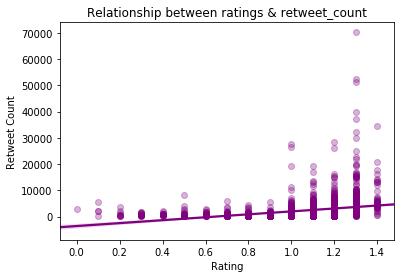

In [49]:
# Relationship between retweet_count and rating
sns.regplot(data = rating_below_2, x = "rating", y = "retweet_count",color='purple',scatter_kws = {'alpha': 0.3})
plt.title('Relationship between ratings & retweet_count')
plt.xlabel('Rating')
plt.ylabel('Retweet Count');

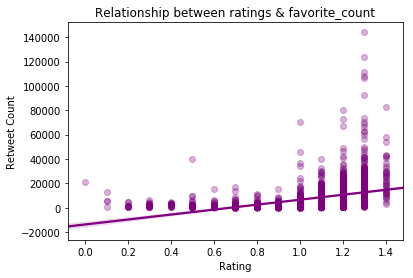

In [50]:
# Relationship between favorite_count and rating
sns.regplot(data = rating_below_2, x = "rating", y = "favorite_count",color='purple',scatter_kws = {'alpha': 0.3})
plt.title('Relationship between ratings & favorite_count')
plt.xlabel('Rating')
plt.ylabel('Retweet Count');

* Two graphs indicate that there seems to have the correlations between retweet_count/ favorite_count and rating. Tweet with higher rating has a tendency to receive more likes and retweets. 
* Rating 13 appears to acquire the highest retweet counts and favorite counts as well.

### Question 2: What are the most popular dog breeds that are tweeted and retweeted and liked?

* The image predictions are the results of a machine learning algorithm trained on a sample of images from the @WeRateDogs tweets. The predictions for each breed contain the probabilities of these predictions to be correct with the certain degree of confidence. My idea of assigning the breed value for each instance is to choose the breed that corresponded to the highest confident prediction.
* There are 1650 non null values of image predictions. I will check which are the highest confident predictions in dogs' breeds for these 1650 observations.

In [51]:
# Check if there is any observation whose prediction confidence is higher than that of prediction 1 
df_highest_confidence_p1 = df_master.query("p1_conf <= p2_conf or p1_conf <= p3_conf")
print("There are "+str(df_highest_confidence_p1.shape[0]) + " observation(s) with higher confidence than p1 in predicting the breeds")

# Check if there is any observation whose prediction confidence is higher than that of prediction 2
df_highest_confidence_p2 = df_master.query("p2_conf <= p1_conf or p2_conf <= p3_conf")
print("There are "+str(df_highest_confidence_p2.shape[0]) + " observation(s) with higher confidence than p2 in predicting the breeds")

# Check if there is any observation whose prediction confidence is higher than that of prediction 3
df_highest_confidence_p3 = df_master.query("p3_conf <= p1_conf or p3_conf <= p2_conf")
print("There are "+str(df_highest_confidence_p3.shape[0]) + " observation(s) with higher confidence than p3 in predicting the breeds")

There are 0 observation(s) with higher confidence than p1 in predicting the breeds
There are 1650 observation(s) with higher confidence than p2 in predicting the breeds
There are 1650 observation(s) with higher confidence than p3 in predicting the breeds


* This indicates that p1_conf values receive the highest confident predictions for dogs' breeds among all 1650 non-null predicted instances. Hence, we will create the new column named 'breed' based on the condition where 'p1_dog==True'. 

In [52]:
# Create the column for dogs'breeds
df_breed = df_master.query("p1_dog==True")
df_breed['breed']=df_breed['p1'].str.title()
df_breed.sample()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,tweet_id,timestamp,text,expanded_urls,name,stage,retweet_count,favorite_count,rating,jpg_url,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed
1834,670676092097810432,2015-11-28 18:50:15,This is Bloo. He's a Westminster Cîroc. Doesn'...,https://twitter.com/dog_rates/status/670676092...,Bloo,NaN,35.0,214.0,0.8,https://pbs.twimg.com/media/CU64WOlWcAA37TV.jpg,...,Dandie_Dinmont,0.676102,True,West_Highland_white_terrier,0.040826,True,clumber,0.039533,True,Dandie_Dinmont


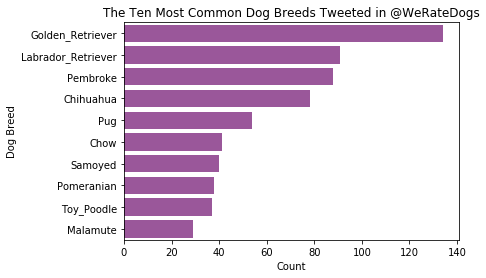

In [53]:
# Plot the top 10 of dog breeds in @WeRateDogs tweets
most_common_breeds = (df_breed.breed.value_counts().head(10).to_frame().reset_index().rename(columns={'index': 'dog_breed', 'breed': 'count'}))
ax = sns.barplot(x='count', y='dog_breed',data=most_common_breeds,color='purple',alpha=0.7);
plt.figure(figsize=(12,8));
ax.set_title('The Ten Most Common Dog Breeds Tweeted in @WeRateDogs');
ax.set_ylabel('Dog Breed');
ax.set_xlabel('Count');

* As shown in the chart, Golden Retriever gets the highest amount of tweets followed by Labrador Retriever. The third most common tweeted breed is Pembroke. Chihuahua and Pug are the fouth and fifth most popular dog breeds in @WeRateDogs Twitter respectively. Chow, Samoyed, Pomeranian, Toy_Poodle and Malamute closely take over from the 6th to the 10th highest ranks of the most popular tweeted dog breeds.
* According to our dataset, Golden Retriever owners are the most active dog owners in writing comments and posting photos of their dogs in Twitter. 

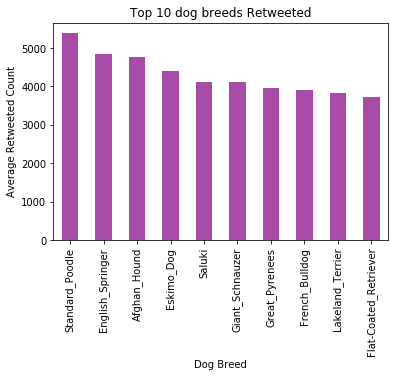

In [54]:
# Top 10 most common dog breeds retweeted
most_common_breed_by_retweeted = df_breed.groupby('breed')['retweet_count'].mean().sort_values(ascending=False).head(10)
most_common_breed_by_retweeted.plot(kind='bar',title='Top 10 dog breeds Retweeted',color='purple',alpha=0.7)
plt.xlabel('Dog Breed')
plt.ylabel('Average Retweeted Count')
plt.xticks(rotation=90);

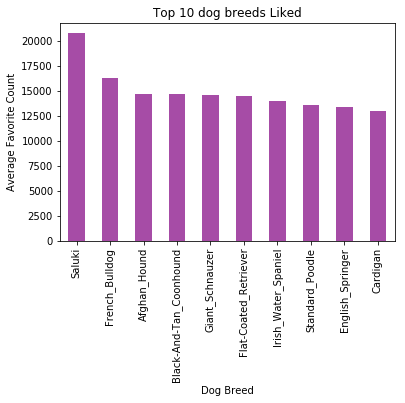

In [55]:
# Top 10 most common dog breeds liked
most_common_breed_by_liked = df_breed.groupby('breed')['favorite_count'].mean().sort_values(ascending=False).head(10)
most_common_breed_by_liked.plot(kind='bar',title='Top 10 dog breeds Liked',color='purple',alpha=0.7)
plt.xlabel('Dog Breed')
plt.ylabel('Average Favorite Count'); 

* Regarding retweet and favorite counts, Standard Poodle, English Springer, Afghan Hound, Saluki, Giant Schnauzer, French Bulldog, Flat Coated Retriever are the seven dog breeds that have both acquired the highest number of retweets and likes in @WeRateDogs Twitter.
* Interestingly, the dog breeds that are tweeted the most are not the ones that receives the highest retweets and favorited. This can be explained in the way that the @WeRateDogs followers appear to interact more on the tweets of about less common dog breeds. 

### Question 3:  Which dog stages are tweeted/ retweeted and liked the most in @WeRateDogs tweets?

In [56]:
# Filter the rows with four dog stages
by_stage = df_master.query('stage=="pupper" or stage=="doggo" or stage=="puppo" or stage=="floofer"')

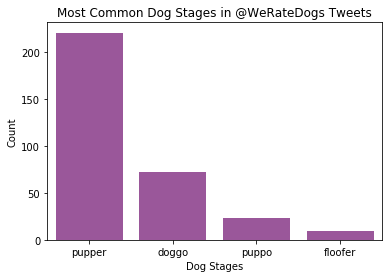

In [57]:
# Plot the most common dog stages tweeted
descending_order=['pupper','doggo','puppo','floofer']
ax = sns.countplot(data=by_stage,x='stage',order=descending_order, color='purple',alpha=0.7);
ax.set_title('Most Common Dog Stages in @WeRateDogs Tweets');
ax.set_xlabel('Dog Stages');
ax.set_ylabel('Count');

* Dog owners seem to post images and write humourous texts on their dogs significantly more frequently when their dogs are puppies. The amount of tweets about puppies doubles that of other dog stages in total. This makes sense because puppies are the most adorable in my opinion. They are more playful and more excited with stuffs around than their mature doggo seniors. Furthermore, pupies are willing to obey their owner's rules way much more than their puppo brothers who are well-known for their stubbornness and rebellion as teenagers going through a transitional phase.

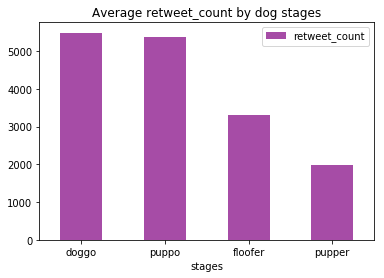

In [58]:
# Plot the average retweet_counts by dog stages 
retweet_count_by_stages = pd.DataFrame(by_stage.groupby('stage').retweet_count.mean().sort_values(ascending=False))
retweet_count_by_stages['stages'] = retweet_count_by_stages.index
retweet_count_by_stages.plot(x="stages",y='retweet_count',kind='bar',title="Average retweet_count by dog stages",color='purple', alpha=0.7);
plt.xticks(rotation=360);

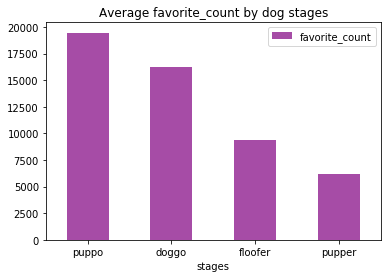

In [59]:
# Plot the Average favorite_count by dog stages
favorite_counts_by_stages = pd.DataFrame(by_stage.groupby('stage').favorite_count.mean().sort_values(ascending=False))
favorite_counts_by_stages['stages'] = favorite_counts_by_stages.index
favorite_counts_by_stages.plot(x="stages",y='favorite_count',kind='bar',title="Average favorite_count by dog stages",color='purple', alpha=0.7);
plt.xticks(rotation=360);

* On contrary to tweets, retweets and likes get favor for puppos and doggos. The number of retweets are as high for puppos as doggos which are over 5k of retwets on average. In term of favorite count, puppos are the winner with almost 20k of favorites which is approximately three times higher than that of puppies. My guess is that with the wide imagination and abundant energy, teenage dogs occupy the most humorous images and comments to be liked among @WeRateDogs community.

<a id='limitations'></a>
### Limitations

* Regards to the relationship between rating and retweet count and favorite count, since this was only an exploratory analysis, these findings do not imply any statistical conclusions. The data should be further inspected with proper statistical test in order to drive more potential correlations.

* Furthermore, one of the limitations of this project is that there is only 15% of the data on dog stages which made it unfeasible to draw accurate conclusions about the popularity of tweets based on the stages of dogs.